# Collision of Two Jovian Planets

* Should I be using classes to model the particles?

## Roadmap
* Initialization
    * Initialize position
        * Use for loop, and make consecutive rings of points
        * SOMETHING ENTIRELY DIFFERENT
    * Initialize velocity
        * Uniform velocity for every particle in planet
    * Initialize mass
        * Every particle gets the same mass
            * For now? Or for always?
    * Assign density $\rho_i$
        * Use [equation 4.5] to assign density
        * $ \rho(r) = \sum_{j=1}^N \rho_j (r)$
    * Choose time scale
        * Time must satisfy the CFL condition [equation 4.12]
        
* Initaliziation (according to [equatoin 4.18])
    * Distribute particles to recover $\rho = \rho_c * sin(\zeta) / \zeta $
        
* Calculate gravitational forces $\nabla \Phi_i$
    * First pass can use brute force O(N^2) method [equation 3.1]
    * Second pass would use trees or FFT
    
* Calculate pressure $P_i$, given density $\rho_i$
    * For the outer layer, $P = \frac{R_g}{\mu} \rho T $
    * More generaly, the 'entire'?? planet can be modeled with $P = K \rho ^\gamma$ 
    * [Equations 4.14 - 4.17] go into more detail

* Calculate $\nabla P_i$
    * Can be done by combining [equations 4.3, 4.4, 4.5, and 4.9]
        * First: calculate Gaussian kernel
        * Second: multiply Gaussian kernel by mass of a specified particle j (this can be done in batch)
        * Third: Sum over local $\rho_j$ to find $\rho_i$
        * Fourth: Sum [ (mass * pressure_j/ density_j) * gradient(kernel) ]
    * Smoothing length
        * First pass: uniform
        * Second pass: locally adaptive

* Calculate change in velocity $v_i$ [equation 4.2], given pressure, density, and gravitational forces
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
* Calculate change in position $r_i$ [equation], given velocity
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
## Weird Things / Concerning Things / Bugs
* When I initalized 100 particles, I ended up with 94 after all of that
    * We lose some of them when rounding, but we shouldn't lose 6
* The max number of particles is not located at the outermost edge of Jupiter
    * This distribution comes from [equation 4.18]. The error might come from the fact that I didn't normalize alpha = 1, rho_c = 1
        
### Initialize Libraries

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

### Initialize Model Constants

In [2]:
RJupiter = 6.99e9    # cm

gamma = 2
G = 6.67e-8    # dyne*cm^2/g^2

rhoC = 5    # g/cm^3, central density
PC = 6.5e13    # dyne/cm^2
TC = 22000    # K

K = 2.6e12    # dyne*cm^4/g^2

alpha = np.sqrt(K/(2*np.pi*G))

### Initialize Positions of Planets

In [25]:
N1 = 1000    # Particles in Planet 1
N2 = N1     # Particles in Planet 2

# Equations 4.17
rNum = 5     
rspace = np.linspace(0, RJupiter, rNum)
zetaspace = rspace/alpha

# Number of particles in each region of delta(r)
NDistribution = []    
for i in range(1,len(zetaspace)):
    zeta2 = zetaspace[i]
    zeta1 = zetaspace[i-1]
    NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
                         *N1/np.pi)
    
NDistribution = np.array(NDistribution)
NDistribution = np.round(NDistribution)

radius1 = []
i = 0
for N in NDistribution:
    radius1.append(np.random.uniform(rspace[i], rspace[i+1], size=N))
    i += 1

# Flatten radial array
radius1 = [item for sublist in radius1 for item in sublist]
radius1 = np.array(radius1)

# Create angle distribution
thetadistribution = np.random.uniform(0, 2*np.pi, size=len(radius1))


c:\Users\oromi_000\Anaconda\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Plot Initial Distribution

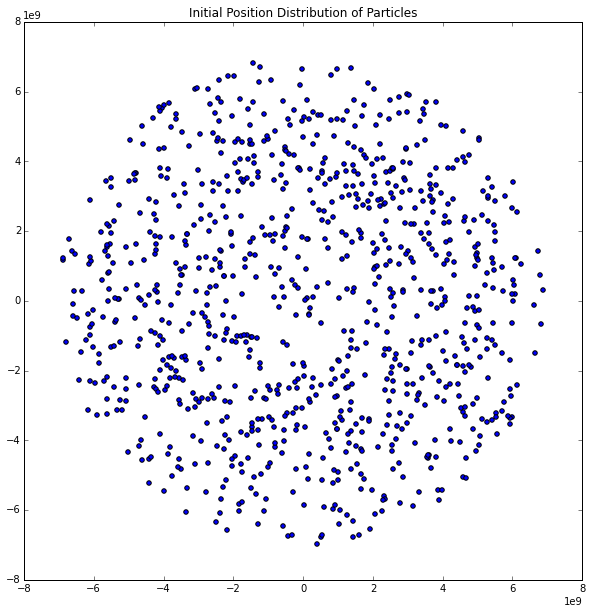

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(radius1*np.cos(thetadistribution), radius1*np.sin(thetadistribution))
plt.title("Initial Position Distribution of Particles")
plt.show()

# Notes
* Make consecutive rings to initialize position. Use a for loop to loop through radii. Increase theta every ring sampling 
    * ie: for r in rlist: for theta in range(2*r): ...